# What is Semantic Segmentation?
Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

# Please upvote the kernel if you found it insightful!

# Import Libraries

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm



from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/016.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/018.png  
  inflating: RGB_

In [ ]:
IMAGE_PATH = '/content/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


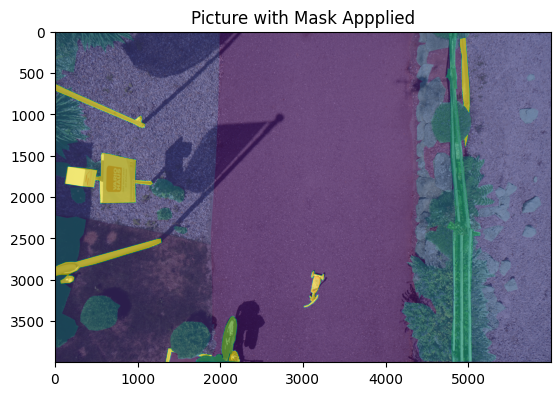

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [ ]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Model

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 408MB/s]


In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
print(criterion)

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.170 
Epoch:1/15.. Train Loss: 2.738.. Val Loss: 2.170.. Train mIoU:0.043.. Val mIoU: 0.095.. Train Acc:0.221.. Val Acc:0.509.. Time: 3.88m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 2.170 >> 1.471 
Epoch:2/15.. Train Loss: 1.845.. Val Loss: 1.471.. Train mIoU:0.119.. Val mIoU: 0.125.. Train Acc:0.583.. Val Acc:0.621.. Time: 3.88m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.471 >> 1.141 
Epoch:3/15.. Train Loss: 1.356.. Val Loss: 1.141.. Train mIoU:0.139.. Val mIoU: 0.163.. Train Acc:0.646.. Val Acc:0.699.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 1.309.. Val Loss: 1.195.. Train mIoU:0.142.. Val mIoU: 0.160.. Train Acc:0.630.. Val Acc:0.654.. Time: 3.85m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.195 >> 1.132 
saving model...
Epoch:5/15.. Train Loss: 1.187.. Val Loss: 1.132.. Train mIoU:0.169.. Val mIoU: 0.174.. Train Acc:0.653.. Val Acc:0.672.. Time: 3.87m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.132 >> 0.877 
Epoch:6/15.. Train Loss: 1.059.. Val Loss: 0.877.. Train mIoU:0.191.. Val mIoU: 0.236.. Train Acc:0.691.. Val Acc:0.740.. Time: 3.85m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/15.. Train Loss: 1.053.. Val Loss: 0.895.. Train mIoU:0.205.. Val mIoU: 0.227.. Train Acc:0.694.. Val Acc:0.746.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.895 >> 0.850 
Epoch:8/15.. Train Loss: 0.919.. Val Loss: 0.850.. Train mIoU:0.227.. Val mIoU: 0.233.. Train Acc:0.734.. Val Acc:0.750.. Time: 3.85m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.850 >> 0.771 
Epoch:9/15.. Train Loss: 0.854.. Val Loss: 0.771.. Train mIoU:0.239.. Val mIoU: 0.252.. Train Acc:0.753.. Val Acc:0.772.. Time: 3.88m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.771 >> 0.716 
Epoch:10/15.. Train Loss: 0.802.. Val Loss: 0.716.. Train mIoU:0.253.. Val mIoU: 0.259.. Train Acc:0.765.. Val Acc:0.777.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.716 >> 0.672 
saving model...
Epoch:11/15.. Train Loss: 0.750.. Val Loss: 0.672.. Train mIoU:0.266.. Val mIoU: 0.286.. Train Acc:0.782.. Val Acc:0.796.. Time: 3.85m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.672 >> 0.638 
Epoch:12/15.. Train Loss: 0.680.. Val Loss: 0.638.. Train mIoU:0.282.. Val mIoU: 0.294.. Train Acc:0.800.. Val Acc:0.803.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:13/15.. Train Loss: 0.671.. Val Loss: 0.647.. Train mIoU:0.290.. Val mIoU: 0.308.. Train Acc:0.804.. Val Acc:0.807.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.647 >> 0.641 
Epoch:14/15.. Train Loss: 0.632.. Val Loss: 0.641.. Train mIoU:0.298.. Val mIoU: 0.303.. Train Acc:0.813.. Val Acc:0.807.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.641 >> 0.637 
Epoch:15/15.. Train Loss: 0.636.. Val Loss: 0.637.. Train mIoU:0.302.. Val mIoU: 0.303.. Train Acc:0.813.. Val Acc:0.810.. Time: 3.85m
Total time: 57.93 m


In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
print(criterion)

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

CrossEntropyLoss()


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.627 
Epoch:1/30.. Train Loss: 0.626.. Val Loss: 0.627.. Train mIoU:0.301.. Val mIoU: 0.310.. Train Acc:0.814.. Val Acc:0.809.. Time: 3.90m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.627 >> 0.625 
Epoch:2/30.. Train Loss: 0.615.. Val Loss: 0.625.. Train mIoU:0.307.. Val mIoU: 0.306.. Train Acc:0.818.. Val Acc:0.810.. Time: 3.88m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/30.. Train Loss: 0.627.. Val Loss: 0.638.. Train mIoU:0.301.. Val mIoU: 0.310.. Train Acc:0.814.. Val Acc:0.807.. Time: 3.90m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/30.. Train Loss: 0.706.. Val Loss: 0.768.. Train mIoU:0.290.. Val mIoU: 0.272.. Train Acc:0.791.. Val Acc:0.770.. Time: 3.85m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:5/30.. Train Loss: 0.751.. Val Loss: 0.902.. Train mIoU:0.279.. Val mIoU: 0.240.. Train Acc:0.778.. Val Acc:0.740.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.902 >> 0.821 
Epoch:6/30.. Train Loss: 0.840.. Val Loss: 0.821.. Train mIoU:0.249.. Val mIoU: 0.255.. Train Acc:0.750.. Val Acc:0.752.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.821 >> 0.790 
saving model...
Epoch:7/30.. Train Loss: 0.838.. Val Loss: 0.790.. Train mIoU:0.248.. Val mIoU: 0.246.. Train Acc:0.751.. Val Acc:0.759.. Time: 3.90m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.790 >> 0.779 
Epoch:8/30.. Train Loss: 0.860.. Val Loss: 0.779.. Train mIoU:0.251.. Val mIoU: 0.270.. Train Acc:0.748.. Val Acc:0.771.. Time: 3.84m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/30.. Train Loss: 0.817.. Val Loss: 0.794.. Train mIoU:0.257.. Val mIoU: 0.255.. Train Acc:0.756.. Val Acc:0.750.. Time: 3.90m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.794 >> 0.677 
Epoch:10/30.. Train Loss: 0.765.. Val Loss: 0.677.. Train mIoU:0.262.. Val mIoU: 0.294.. Train Acc:0.769.. Val Acc:0.787.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:11/30.. Train Loss: 0.771.. Val Loss: 0.754.. Train mIoU:0.272.. Val mIoU: 0.285.. Train Acc:0.771.. Val Acc:0.775.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.754 >> 0.681 
Epoch:12/30.. Train Loss: 0.744.. Val Loss: 0.681.. Train mIoU:0.284.. Val mIoU: 0.303.. Train Acc:0.778.. Val Acc:0.793.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.681 >> 0.660 
Epoch:13/30.. Train Loss: 0.677.. Val Loss: 0.660.. Train mIoU:0.304.. Val mIoU: 0.308.. Train Acc:0.795.. Val Acc:0.789.. Time: 3.86m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:14/30.. Train Loss: 0.646.. Val Loss: 0.668.. Train mIoU:0.320.. Val mIoU: 0.331.. Train Acc:0.806.. Val Acc:0.805.. Time: 3.89m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.668 >> 0.575 
saving model...
Epoch:15/30.. Train Loss: 0.594.. Val Loss: 0.575.. Train mIoU:0.333.. Val mIoU: 0.369.. Train Acc:0.821.. Val Acc:0.829.. Time: 3.91m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.575 >> 0.545 
Epoch:16/30.. Train Loss: 0.561.. Val Loss: 0.545.. Train mIoU:0.359.. Val mIoU: 0.388.. Train Acc:0.831.. Val Acc:0.836.. Time: 3.91m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 66.06 m


In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))